In [1]:
%matplotlib inline
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

In [6]:
class MyDataset(Dataset):

    def __init__(self, csv_path, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = df["File Directory"]
        self.img_names = df['File Name']
        self.y = df['Class Label']
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir[index],
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [7]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50

set_all_seeds(RANDOM_SEED)
#set_deterministic()

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [8]:
custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.), # not necessary
    transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


train_dataset = MyDataset(csv_path='df_train.csv',
                          transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0) # number processes/CPUs to use


valid_dataset = MyDataset(csv_path='df_val.csv',
                          transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)


test_dataset = MyDataset(csv_path='df_test.csv',
                         transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=0)

In [9]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0])


# AlexNet

In [10]:
class AlexNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

Epoch: 001/050 | Batch 0000/0039 | Loss: 0.6928
Epoch: 001/050 | Train: 86.79% | Validation: 85.25%
Time elapsed: 0.75 min
Epoch: 002/050 | Batch 0000/0039 | Loss: 0.2976
Epoch: 002/050 | Train: 95.28% | Validation: 94.00%
Time elapsed: 1.47 min
Epoch: 003/050 | Batch 0000/0039 | Loss: 0.1299
Epoch: 003/050 | Train: 95.83% | Validation: 94.75%
Time elapsed: 2.19 min
Epoch: 004/050 | Batch 0000/0039 | Loss: 0.1746
Epoch: 004/050 | Train: 97.61% | Validation: 96.25%
Time elapsed: 2.91 min
Epoch: 005/050 | Batch 0000/0039 | Loss: 0.0711
Epoch: 005/050 | Train: 98.23% | Validation: 97.62%
Time elapsed: 3.63 min
Epoch: 006/050 | Batch 0000/0039 | Loss: 0.0431
Epoch: 006/050 | Train: 97.37% | Validation: 97.12%
Time elapsed: 4.35 min
Epoch: 007/050 | Batch 0000/0039 | Loss: 0.1016
Epoch: 007/050 | Train: 98.55% | Validation: 97.75%
Time elapsed: 5.07 min
Epoch: 008/050 | Batch 0000/0039 | Loss: 0.0271
Epoch: 008/050 | Train: 98.38% | Validation: 97.88%
Time elapsed: 5.78 min
Epoch: 009/050 |

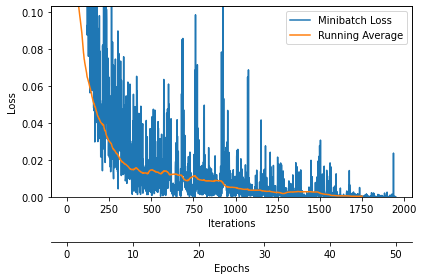

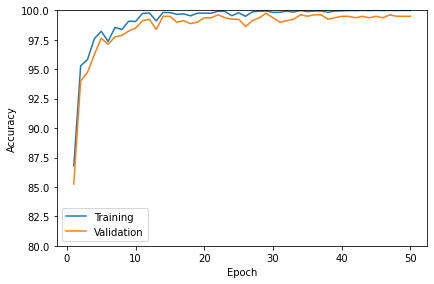

In [11]:
model = AlexNet(num_classes=2)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

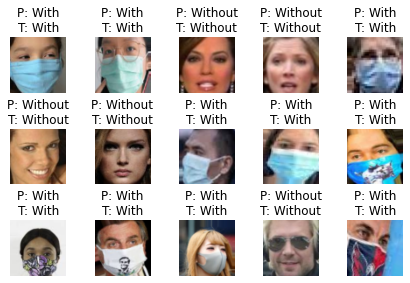

In [12]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'Without',
              1: 'With'
              }

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

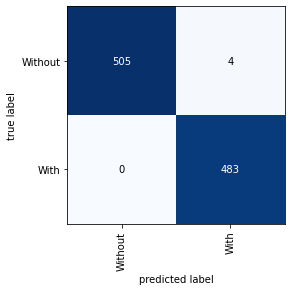

In [13]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()